In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# to get deterministic output
#torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Hyperparameters

In [2]:
batch_size = 128
lr = 0.001
epochs = 10
image_size = 32
channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DataLoader

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_ds = datasets.CIFAR10(root="../datasets/cifar10", train=True, download=True, transform=transform_train)
test_ds = datasets.CIFAR10(root="../datasets/cifar10", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=False, num_workers=2)

print("Train set:", len(train_ds))
print("Test set :", len(test_ds))

Train set: 50000
Test set : 10000


### Visualize the Dataset

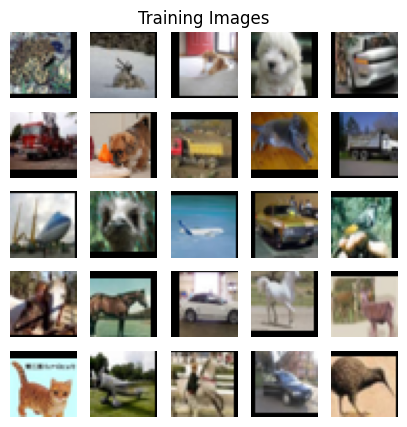

In [4]:
for images, _ in train_loader:  
    break

grid = images * 0.5 + 0.5  # denormalize
grid = grid.numpy().transpose(0, 2, 3, 1)

plt.figure(figsize=(5,5))
plt.title("Training Images")
plt.axis("off")
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(grid[k], cmap="gray")
    plt.axis("off")
plt.show()

### Load Pretrained Model

In [ ]:
# load model with pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
# model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
# model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

# freeze all convolutional layers
# for param in model.parameters():
#     param.requires_grad = False

# train only the last layer
# optimizer = optim.Adam(model.fc.parameters(), lr=lr) 

# replace final fully connected layer: ResNet18 outputs 1000 classes by default
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training Loop

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch:03d}/{epochs:03d} | "
                  f"Step: {batch_idx:03d}/{len(train_loader)} | Loss: {loss.item():.4f}")

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

# -------------------------
# Run Training
# -------------------------
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch+1)
    test(model, device, test_loader)


Epoch: 001/010 | Step: 000/391 | Loss: 2.7295
Epoch: 001/010 | Step: 100/391 | Loss: 1.1777
Epoch: 001/010 | Step: 200/391 | Loss: 0.8820
Epoch: 001/010 | Step: 300/391 | Loss: 0.7796
Test Accuracy: 69.58%
Epoch: 002/010 | Step: 000/391 | Loss: 0.9970
Epoch: 002/010 | Step: 100/391 | Loss: 0.7432
Epoch: 002/010 | Step: 200/391 | Loss: 0.7713
Epoch: 002/010 | Step: 300/391 | Loss: 0.6660
Test Accuracy: 76.38%
Epoch: 003/010 | Step: 000/391 | Loss: 0.7483
Epoch: 003/010 | Step: 100/391 | Loss: 0.6851
Epoch: 003/010 | Step: 200/391 | Loss: 0.5834
Epoch: 003/010 | Step: 300/391 | Loss: 0.6158
Test Accuracy: 79.04%
Epoch: 004/010 | Step: 000/391 | Loss: 0.6216
Epoch: 004/010 | Step: 100/391 | Loss: 0.6273
Epoch: 004/010 | Step: 200/391 | Loss: 0.7011
Epoch: 004/010 | Step: 300/391 | Loss: 0.5242
Test Accuracy: 77.09%
Epoch: 005/010 | Step: 000/391 | Loss: 0.6543
Epoch: 005/010 | Step: 100/391 | Loss: 0.6601
Epoch: 005/010 | Step: 200/391 | Loss: 0.5122
Epoch: 005/010 | Step: 300/391 | Loss: